In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
import xarray as xr
#from telemetry_module import *
from copy import deepcopy
import pickle
import matplotlib as mpl
from scipy import interpolate
import time
from scipy.special import expit
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

In [3]:
#from bayesfilt.telemetry.utils import *
from bayesfilt.filters.utils import get_covariance_ellipse
#from bayesfilt.telemetry.utils import get_bound_from_positions, plot_relation
from simulate_tracks import *
from csg_resample_ks import *
data_dir = os.path.join(CSG_DIR, 'raw_data')

In [4]:
%%time
df, variables = get_annotated_telemetry_df()

CPU times: user 16.9 s, sys: 13.5 s, total: 30.4 s
Wall time: 31.2 s


In [5]:
dfshort = get_dfshort(df)

2928522
22.569345594852887 1000000


In [29]:
[ix for ix in df.columns if 'Track' in ix]

['TrackID', 'TrackTimeElapsed']

In [33]:
for igroup in ['pa','wy']:
#     vbool = (vdf['Group']==igroup) & ((vdf['TrackID']>0))
#     print(igroup, vbool.sum()/(vdf['Group']==igroup).sum())
#     print(igroup, vdf[vbool].TrackID.nunique())
#     print(igroup, vdf[vbool].AnimalID.nunique())
    cbool = (df['Group']==igroup) & ((df['AltitudeAgl']<200))
    #print(igroup, df[cbool].shape[0]/df[df['Group']==igroup].shape[0])
    print(igroup, df[cbool].shape[0]/60./60.)
#     print(igroup, vdf[vdf['Group']==igroup].shape)
#     print(igroup, cdf[cdf['Group']==igroup].TimeLocal.min())
#     print(igroup, cdf[cdf['Group']==igroup].TimeLocal.max())
# #     vbool = (cdf['Group']==igroup) & ((cdf['TrackID']>0))
#     print(igroup, vbool.sum()/(cdf['Group']==igroup).sum())

pa 101.84055555555555
wy 1332.4502777777777


In [6]:
df[df['Group']=='pa'].AnimalID.unique()

[75, 251, 252, 253, 333, 572, 651, 652, 662]
Categories (44, int64): [305, 594, 667, 678, ..., 674, 675, 681, 684]

In [7]:
df[df['Group']=='pa']

,AccelerationVer,AccelerationX,AccelerationX_var,AccelerationY,AccelerationY_var,AccelerationZ_var,AccnHorRadial,AccnHorTangential,Age,Altitude,...,HeadingRateFd,AccelerationVerB,HeadingRateAbs,HeadingRateFdAbs,WindLateral80mAbs,HrateByHspeed,VelocityHorVar,VelocityHorRel,HeadingRateFdSmooth,HeadingRateSmooth
669280,-0.007902,1.332093,0.703350,-2.866887,0.703350,0.007459,2.783273,-1.498969,A,800.224609,...,-155.202438,3.384038,49.149628,155.202438,0.809971,-98.299255,2.456956,1.453505,-48.100436,-22.922699
669281,-0.007822,1.508731,0.494767,-3.029850,0.494767,0.006848,2.928327,1.697399,A,800.174866,...,-41.383667,-0.049748,50.010956,41.383667,0.345384,-18.762724,1.448769,4.282566,-52.204739,-24.277234
669282,-0.007646,1.546320,0.403996,-2.849789,0.403996,0.006257,1.669488,2.779426,A,800.117310,...,-45.338013,-0.007812,16.222565,45.338013,1.392099,-3.638138,0.978764,5.350019,-53.378207,-24.852594
669283,-0.007400,1.321197,0.388752,-2.307310,0.388752,0.005691,0.965272,2.477396,A,800.052063,...,-19.977600,-0.007690,6.293976,19.977600,1.611756,-0.872500,0.683515,7.575799,-23.564270,-15.119635
669284,-0.007117,0.868709,0.380756,-1.490645,0.380756,0.005156,0.503179,1.650300,A,799.979309,...,-4.989319,-0.007507,2.585846,4.989319,1.635933,-0.250313,0.523967,10.551482,-14.632166,-4.831439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430486,-0.033443,-1.010836,0.666949,-0.917688,0.666949,0.008931,-1.151017,0.734235,J,1224.769043,...,4.796570,-0.033569,4.201538,4.796570,0.674016,0.274383,1.505963,9.645910,4.174329,4.121094
1430487,-0.033436,-1.034441,0.978835,-0.928465,0.978835,0.009535,-1.120948,0.821943,J,1223.820190,...,4.265747,-0.033447,3.898560,4.265747,1.093361,0.239787,1.291116,10.656821,3.814709,3.860168
1430488,-0.033433,-1.045875,1.380472,-0.933685,1.380472,0.010149,-1.076763,0.897889,J,1222.838013,...,3.992889,-0.033325,3.558990,3.992889,1.480462,0.211362,2.167733,11.325750,3.965460,3.554327
1430489,-0.033432,-1.049563,1.841677,-0.935369,1.841677,0.010771,-1.025480,0.961712,J,1221.822388,...,3.412048,-0.033447,3.216766,3.412048,1.805618,0.179354,5.231079,12.519729,29.952338,2.555627


In [8]:
#df['HeadingRateFdSmooth'] = df['HeadingRateFd'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['HeadingRateSmooth'] = df['HeadingRate'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['AccnHorSmooth'] = df['AccelerationHor'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['AccnHorSmoothAbs'] = df['AccnHorSmooth'].abs()

In [9]:
#df[['Heading','HeadingRate','HeadingRateSmooth', 'HeadingRateFd', 'HeadingRateFdSmooth']].iloc[112000:112020]

In [10]:
xnames = {
    0: ('0 m', 'OroSmooth'), 
    40: ('40 m', 'OroSmoothD40'),
    50: ('50 m', 'OroSmoothD50'),
    60: ('60 m', 'OroSmoothD60'),
    80: ('80 m', 'OroSmoothD80'),
    100: ('100 m', 'OroSmoothD100'),
    120: ('120 m', 'OroSmoothD120'),
    200: ('200 m', 'OroSmoothD200'),
    250: ('250 m', 'OroSmoothD250'),
    300: ('300 m', 'OroSmoothD300'),
    400: ('400 m', 'OroSmoothD400'),
    500: ('500 m', 'OroSmoothD500'),
    # 600: ('600 m', 'OroSmoothD600'),
    # 800: ('800 m', 'OroSmoothD800'),
    # 1000: ('1 km', 'OroSmoothD1000'),
    #2000: ('2 km', 'OroSmoothD2000'),
}
plot_dists = [0,50,100,200,300,500]

## Heading rate vs updrafts

In [11]:
%%time
yname = 'HeadingRate'
hr_dict = {}
for i, (xdist, (xlbl, xname)) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(dfshort, xname, yname, nn=7, qq=0.5, quant=0.95)
    hr_dict[xdist] = (xdata, ydata, ystd)

CPU times: user 2.57 s, sys: 8.05 ms, total: 2.58 s
Wall time: 2.58 s


In [12]:
list_of_dists = (40, 50, 60, 80, 100, 120, 200, 250, 300)
list_of_angles = (-60,-30,-15,15,30,60)
for idist in list_of_dists:
    for iangle in list_of_angles:
        iflag = f'L{int(abs(iangle))}' if iangle <0 else f'R{int(iangle)}'
        target_var = f'OroSmoothD{str(idist)}{iflag}'
        base_var = f'OroSmoothD{str(idist)}'
        out_var = f'OroSmoothD{str(idist)}{iflag}Diff'
        dfshort[out_var] = dfshort[target_var] - dfshort[base_var]

fig_lookahead_headingrate_15.png
fig_lookahead_headingrate_30.png
fig_lookahead_headingrate_60.png


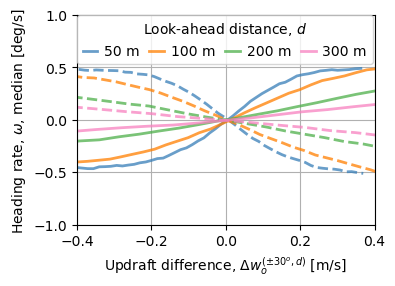

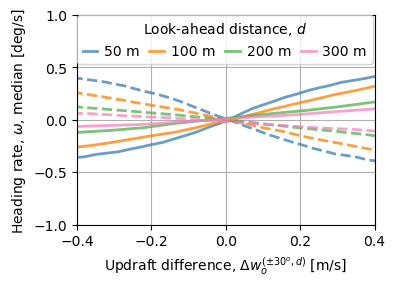

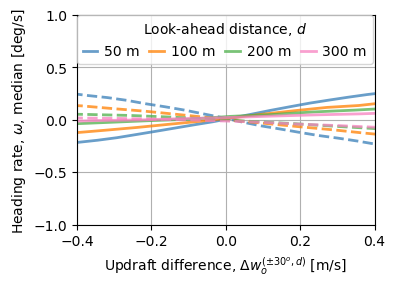

In [13]:
idf = dfshort
qval = 0.99
nval = 15
mval = 0.5
yname = 'HeadingRate'
for iangle in [15,30,60]:
    fig, ax = plt.subplots()
    for i, idist in enumerate([50,100,200,300]):
        xname = f'OroSmoothD{str(idist)}R{int(iangle)}Diff'
        xgrid = np.linspace(*np.quantile(idf[xname], [1 - qval, qval]), 50)
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
        xname = f'OroSmoothD{str(idist)}L{int(iangle)}Diff'
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        ax.plot(xdata, ydata, '--r', color=clrs[i], linewidth=2, alpha=0.75)
        ax.set_xlabel(r'Updraft difference, $\Delta w_o^{(\pm 30^o,d)}$ [m/s] ')
    ax.set_ylabel(r'Heading rate, $\omega$, median [deg/s]')
    ax.grid(True)
    ax.set_xlim([-0.4,0.4])
    ax.set_ylim([-1,1])
    lg = ax.legend(
        loc=2, borderaxespad=0., ncol=4, title=r'Look-ahead distance, $d$',
        handlelength=1.05, handletextpad=0.5, columnspacing=0.7, fancybox=True
    )
    #lg.get_title().set_fontsize('9')
    ax.set_yticks([-1, -0.5,  0, 0.5, 1])   
    fig.set_size_inches(4.25/1.1, 3./1.1)
    fig.subplots_adjust(left=0.18, bottom=0.18, right=0.95, top=0.95)
    fname = f'fig_lookahead_{yname.lower()}_{int(iangle)}.png'
    print(fname)
    fig.savefig(os.path.join(FIG_DIR, fname), dpi=200)
    #save_paper_figure(fig, name=f'lookahead_{yname}_{int(iangle)}')

In [24]:
idf = dfshort
qval = 0.9
nval = 9
mval = 0.5
yname = 'HeadingRate'
slope_dict = {}
for iangle in [15,30,60]:
    slope_dict[iangle] = []
    slope_dict[-iangle] = []
    for i, idist in enumerate(list_of_dists):
        xname = f'OroSmoothD{str(idist)}R{int(iangle)}Diff'
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        z = np.polyfit(xdata, ydata, 1)
        slope_dict[iangle].append(z[0])
        xname = f'OroSmoothD{str(idist)}L{int(iangle)}Diff'
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        z = np.polyfit(xdata, ydata, 1)
        slope_dict[-iangle].append(z[0])

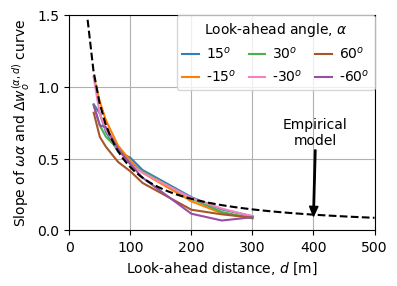

In [25]:
fig, ax = plt.subplots()
for i, (ikey, ival) in enumerate(slope_dict.items()):
    ax.plot(list_of_dists, np.array(ival)*np.radians(ikey), '-r', color=clrs[i], label=f'{ikey}' + r'$^o$')
xx = np.linspace(30,500,50)
yy = 1.4*np.exp(-(xx/115))
zz = 44/xx
#ax.plot(xx,yy,'--k')
ax.plot(xx,zz,'--k', linewidth=1.5)
ax.legend(borderaxespad=0., ncol=3, loc=1, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlim([0,500])
ax.set_ylim([0.,1.5])
ax.set_xlabel(r'Look-ahead distance, $d$ [m]')
ax.set_ylabel(r'Slope of $\omega \alpha$ and $\Delta w_o^{(\alpha,d)}$ curve', rotation='vertical')
ax.set_xlim([0,500])
lg = ax.legend(
        loc=1, borderaxespad=0., ncol=3, title=r'Look-ahead angle, $\alpha$', 
        handlelength=1.2, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
#lg.get_title().set_fontsize('10')
ax.set_yticks([0,0.5,1.,1.5])
ax.annotate('Empirical\nmodel', xy=(400,0.1), xytext=(350,0.6), 
            arrowprops=dict(width=1., headwidth=6., headlength=7., ec='k', fc='k'), ma='center')
# ax.set_yticks(['50 m', '100 m'])
fig.set_size_inches(4.25/1.1, 3./1.1)
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.95)
fig.savefig(os.path.join(FIG_DIR, f'fig_lookahead_model'), dpi=200)

## Heading rate std

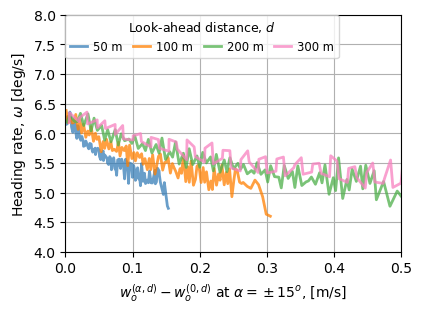

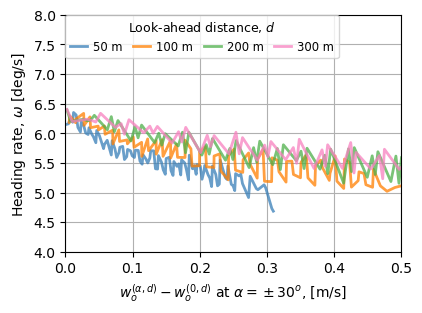

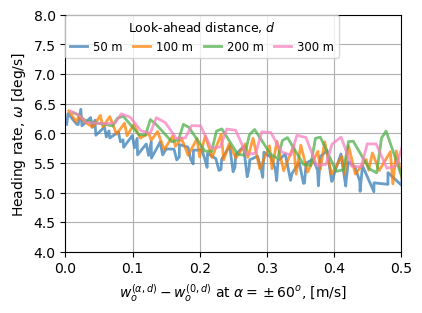

In [16]:
idf = dfshort
qval = 0.95
nval = 11
mval = 0.5
yname = 'HeadingRate'
for iangle in [15,30,60]:
    fig, ax = plt.subplots()
    for i, idist in enumerate([50,100,200,300]):
        xname = f'OroSmoothD{str(idist)}R{int(iangle)}Diff'
        xdata_r, ydata_r, ystd_r = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        #ax.plot(xdata, ystd, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
        xname = f'OroSmoothD{str(idist)}L{int(iangle)}Diff'
        xdata_l, ydata_, ystd_l = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        xdata = np.concatenate([xdata_l, xdata_r])
        ystd = np.concatenate([ystd_l, ystd_r])
        inds = np.abs(xdata).argsort()
        xdata = np.abs(xdata[inds])
        ystd = ystd[inds]
        ax.plot(xdata, ystd, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
        ax.set_xlabel(r'$w_o^{(\alpha,d)} - w_o^{(0,d)}$ at $\alpha = \pm$' + f'{iangle}' + r'$^o$, [m/s] ')
    ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
    ax.grid(True)
    ax.set_xlim([0,0.5])
    ax.set_ylim([4,8])
    lg = ax.legend(
        loc=2, borderaxespad=0., ncol=4, title=r'Look-ahead distance, $d$', fontsize='small',
        handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
    )
    lg.get_title().set_fontsize('9')
    #ax.set_yticks([-1, -0.5,  0, 0.5, 1])   
    save_paper_figure(fig, name=f'lookahead_{yname}_{int(iangle)}_std')

In [17]:
idf = dfshort
qval = 0.9
nval = 9
mval = 0.5
yname = 'HeadingRate'
slope_dict = {}
intercept_dict = {}
for iangle in [15,30,60]:
    slope_dict[iangle] = []
    intercept_dict[iangle] = []
    for i, idist in enumerate(list_of_dists):
        xname = f'OroSmoothD{str(idist)}R{int(iangle)}Diff'
        xdata_r, ydata_r, ystd_r = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        #ax.plot(xdata, ystd, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
        xname = f'OroSmoothD{str(idist)}L{int(iangle)}Diff'
        xdata_l, ydata_, ystd_l = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        xdata = np.concatenate([xdata_l, xdata_r])
        ystd = np.concatenate([ystd_l, ystd_r])
        inds = np.abs(xdata).argsort()
        xdata = np.abs(xdata[inds])
        ystd = ystd[inds]
        z = np.polyfit(xdata, ystd, 1)
        slope_dict[iangle].append(z[0])
        intercept_dict[iangle].append(z[1])

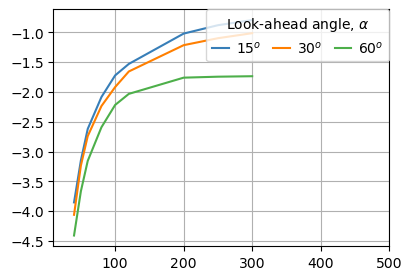

In [18]:
fig, ax = plt.subplots()
for i, (ikey, ival) in enumerate(slope_dict.items()):
    ax.plot(list_of_dists, np.array(ival)*np.power(np.radians(ikey),1), '-r', color=clrs[i], label=f'{ikey}' + r'$^o$')
# xx = np.linspace(30,500,50)
# yy = 1.4*np.exp(-(xx/115))
# zz = 44/xx
# #ax.plot(xx,yy,'--k')
# ax.plot(xx,zz,'--k', linewidth=1.5)
ax.legend(borderaxespad=0., ncol=3, loc=1, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlim([0,500])
#ax.set_ylim([0.,1.5])
#ax.set_xlabel(r'Look-ahead distance, $d$ [m]')
#x.set_ylabel(r'Slope: $\omega$ -- $(w_o^{(\alpha,d)} - w_o^{(0,d)})/\alpha}$', rotation='vertical')
ax.set_xlim([10,500])
lg = ax.legend(
        loc=1, borderaxespad=0., ncol=3, title=r'Look-ahead angle, $\alpha$', 
        handlelength=1.2, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('10')
#ax.annotate('Empirical\nmodel', xy=(400,0.1), xytext=(350,0.6), arrowprops=dict(width=1., headwidth=6., headlength=7., ec='k', fc='k'), ma='center')
#ax.set_xlabelticks(['50 m', '100 m'])
save_paper_figure(fig, name=f'fig_lookahead_{yname}_model_std')

## Heading rate vs agl

In [19]:
xnames_agl = {
    0: ('0 m', ''), 
    40: ('40 m', 'ElevD40'),
    50: ('50 m', 'ElevD50'),
    60: ('60 m', 'ElevD60'),
    80: ('80 m', 'ElevD80'),
    100: ('100 m', 'ElevD100'),
    120: ('120 m', 'ElevD120'),
    200: ('200 m', 'ElevD200'),
    250: ('250 m', 'ElevD250'),
    300: ('300 m', 'ElevD300'),
    400: ('400 m', 'ElevD400'),
    500: ('500 m', 'ElevD500'),
    # 600: ('600 m', 'OroSmoothD600'),
    # 800: ('800 m', 'OroSmoothD800'),
    # 1000: ('1 km', 'OroSmoothD1000'),
    #2000: ('2 km', 'OroSmoothD2000'),
}

In [20]:
%%time
yname = 'HeadingRateNext'
hr_dict = {}
for i, (xdist, (xlbl, xname)) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(dfshort, xname, yname, nn=7, qq=0.5, quant=0.95)
    hr_dict[xdist] = (xdata, ydata, ystd)

KeyError: 'HeadingRateNext'

In [21]:
list_of_dists = (40, 50, 60, 80, 100, 120, 200, 250, 300)
list_of_angles = (-60,-30,-15,15,30,60)
for idist in list_of_dists:
    for iangle in list_of_angles:
        iflag = f'L{int(abs(iangle))}' if iangle <0 else f'R{int(iangle)}'
        target_var = f'ElevD{str(idist)}{iflag}'
        base_var = f'ElevD{str(idist)}'
        out_var = f'ElevD{str(idist)}{iflag}Diff'
        dfshort[out_var] = dfshort[target_var] - dfshort[base_var]

KeyError: 'HeadingRateNext'

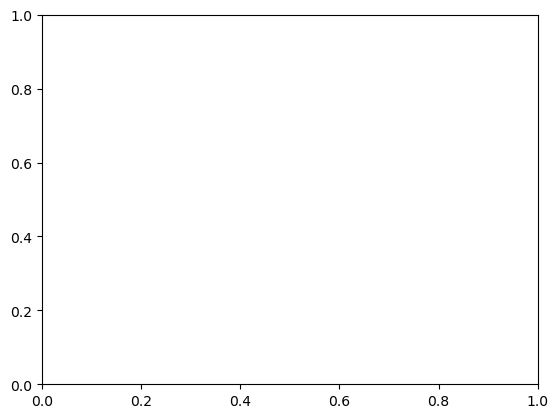

In [22]:
idf = dfshort
qval = 0.99
nval = 15
mval = 0.5
yname = 'HeadingRateNext'
for iangle in [15,30,60]:
    fig, ax = plt.subplots()
    for i, idist in enumerate([50,100,200,300]):
        xname = f'ElevD{str(idist)}R{int(iangle)}Diff'
        xgrid = np.linspace(*np.quantile(idf[xname], [1 - qval, qval]), 50)
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
        xname = f'ElevD{str(idist)}L{int(iangle)}Diff'
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        ax.plot(xdata, ydata, '--r', color=clrs[i], linewidth=2, alpha=0.75)
        ax.set_xlabel(r'$w_o^{(\alpha,d)} - w_o^{(0,d)}$ at $\alpha = \pm$' + f'{iangle}' + r'$^o$, [m/s] ')
    ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
    ax.grid(True)
    ax.set_xlim([-20,20])
    #ax.set_ylim([-1,1])
    lg = ax.legend(
        loc=2, borderaxespad=0., ncol=4, title=r'Look-ahead distance, $d$', fontsize='small',
        handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
    )
    lg.get_title().set_fontsize('9')
    #ax.set_yticks([-1, -0.5,  0, 0.5, 1])   
    save_paper_figure(fig, name=f'lookahead_{yname}_elev_{int(iangle)}')

## Vertical velocity

In [ ]:
%%time
yname = 'VelocityVerNext'
vz_dict = {}
for i, (xdist, (xlbl, xname)) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(dfshort, xname, yname, nn=7, qq=0.5, quant=0.95)
    vz_dict[xdist] = (xdata, ydata, ystd)

In [ ]:
fig, ax = plt.subplots()
for i, xdist in enumerate(plot_dists):
    xdata, ydata, ystd = vz_dict[xdist]
    ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=xnames[xdist][0])
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,2])
ax.set_ylim([-0.1,0.1])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=3, title=r'Look-ahead distance, $d$', fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('10')
ax.set_yticks([-0.1,0.0,0.1])                           
save_paper_figure(fig, name=f'fig_lookahead_vz_median', w=4.5)

In [ ]:
fig, ax = plt.subplots()
for i, xdist in enumerate(plot_dists):
    xdata, ydata, ystd = vz_dict[xdist]
    ax.plot(xdata, ystd, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=xnames[xdist][0])
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Std deviation of $v_z$, [m/s]')
ax.grid(True)
ax.set_xlim([0,2])
ax.set_ylim([0.5,2.])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=3, title=r'Look-ahead distance, $d$', fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('10')
#ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                           
save_paper_figure(fig, name=f'fig_lookahead_vz_std')

In [ ]:
def func_vz(pars, ixdata):
    return pars[3] + expit(pars[2]*(ixdata-pars[1]))*pars[0]*ixdata
fig, ax = plt.subplots()
idict = {}
for i, (idist, (xdata,ydata,ystd)) in enumerate(vz_dict.items()):
    this_func = lambda pars : np.sum(np.square(ydata-func_vz(pars,xdata)))
    res = minimize(this_func, [50,0.75,2,-0.07], method='nelder-mead', options={'xatol': 1e-18,'fatol': 1e-18, 'disp': False, 'maxiter':1000, 'maxfev':1000})
    newy = func_vz(res.x, xdata)
    idict[idist] = res.x
    print(idist, res.x)
    #if i==3:
    #if idist in plot_dists:
    ax.plot(xdata, ydata, '-r', linewidth=1.5, alpha=0.75, label=xnames[idist][0])
    ax.plot(xdata, newy, '--r', linewidth=1.5, alpha=0.75)
idict = pd.DataFrame(idict).transpose().reset_index()
idict.columns = ['dist','x0','x1','x2','x3']      
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,3])
#ax.set_ylim([-0.1,0.3])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=3, title=r'Look-ahead distance, $d$', fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('10')
ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                           
save_paper_figure(fig, name=f'fig_lookahead_vz_median_fitting',w=4.5)

In [ ]:
fig, ax = plt.subplots()
ax.plot(idict.dist, idict.x1,'-r', color=clrs[0])
ax.set_xlabel(r'Look-ahead distance, $d$ [m]')
ax.set_ylabel(r'Threshold coefficient, $c_1$ [m/s]', color=clrs[0])
ax.tick_params(axis='y', labelcolor=clrs[0])
ax.grid(True)
ax.set_xlim([0,500])
ax.set_ylim([0.5,1.5])
ax2 = ax.twinx() 
ax2.plot(idict.dist, idict.x0,'--b', color=clrs[1])
ax2.set_ylabel(r'Reaction coefficient, $c_2$ [1/s]', color=clrs[1])
ax2.tick_params(axis='y', labelcolor=clrs[1])
save_paper_figure(fig, name=f'fig_lookahead_vz_distmodel',w=4.5)
#ax2.set_ylim([0.05,2])
#ax.plot(jdict.dist, 0.1-0.0001*jdict.dist,'-b')

## Horizontal velocity

In [ ]:
%%time
yname = 'VelocityHorNext'
vh_dict = {}
for i, (xdist, (xlbl, xname)) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(dfshort, xname, yname, nn=11, qq=0.5, quant=0.95)
    vh_dict[xdist] = (xdata, ydata, ystd)

In [ ]:
fig, ax = plt.subplots()
for i, xdist in enumerate(plot_dists):
    xdata, ydata, ystd = vh_dict[xdist]
    ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=xnames[xdist][0])
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,2])
ax.set_ylim([10.5,13])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=3, title=r'Look-ahead distance, $d$', fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('10')
#ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                           
save_paper_figure(fig, name=f'fig_lookahead_vh_median', w=4.5)

In [ ]:
fig, ax = plt.subplots()
for i, xdist in enumerate(plot_dists):
    xdata, ydata, ystd = vh_dict[xdist]
    ax.plot(xdata, ystd, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=xnames[xdist][0])
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Std deviation of $v_z$, [m/s]')
ax.grid(True)
ax.set_xlim([0,2])
ax.set_ylim([4,8])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=3, title=r'Look-ahead distance, $d$', fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('10')
#ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                           
save_paper_figure(fig, name=f'fig_lookahead_vh_std')

In [ ]:
def func_vh(pars, ixdata):
    return -1.2*ixdata + 11.6 + 1*expit(2*(ixdata-pars[1]))*(pars[0]*ixdata)
fig, ax = plt.subplots()
idict = {}
for i, (idist, (xdata,ydata,ystd)) in enumerate(vh_dict.items()):
    this_func = lambda pars : np.sum(np.square(ydata-func_vh(pars,xdata)))
    res = minimize(this_func, [1, 1, 2, -0.2, 11], method='nelder-mead', options={'xatol': 1e-18,'fatol': 1e-18, 'disp': False, 'maxiter':1000, 'maxfev':1000})
    newy = func_vh(res.x, xdata)
    idict[idist] = res.x
    print(idist, np.round(res.x,4))
    if i==0:
    #if idist in plot_dists:
        ax.plot(xdata, ydata, '-r', linewidth=1.5, alpha=0.75, label=xnames[idist][0])
        ax.plot(xdata, newy, '--r', linewidth=1.5, alpha=0.75)
idict = pd.DataFrame(idict).transpose().reset_index()
idict.columns = ['dist','x0','x1','x2','x3','x4']      
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,3])
#ax.set_ylim([-0.1,0.3])
# lg = ax.legend(
#     loc=2, borderaxespad=0., ncol=3, title=r'Look-ahead distance, $d$', fontsize='small',
#     handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
# )
# lg.get_title().set_fontsize('10')
#ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                           
save_paper_figure(fig, name=f'fig_lookahead_vh_median_fitting',w=4.5)

In [ ]:
fig, ax = plt.subplots()
ax.plot(idict.dist, idict.x0,'-r', color=clrs[0])
ax.set_xlabel(r'Look-ahead distance, $d$ [m]')
ax.set_ylabel(r'Threshold coefficient, $c_1$ [m/s]', color=clrs[0])
ax.tick_params(axis='y', labelcolor=clrs[0])
ax.grid(True)
ax.set_xlim([0,500])
#ax.set_ylim([0.5,1.5])
ax2 = ax.twinx() 
ax2.plot(idict.dist, idict.x1,'--b', color=clrs[1])
ax2.set_ylabel(r'Reaction coefficient, $c_2$ [1/s]', color=clrs[1])
ax2.tick_params(axis='y', labelcolor=clrs[1])
save_paper_figure(fig, name=f'fig_lookahead_vh_distmodel',w=4.5)
#ax2.set_ylim([0.05,2])
#ax.plot(jdict.dist, 0.1-0.0001*jdict.dist,'-b')

## heading rate

In [ ]:
%%time
yname = 'VelocityVerNext'
hr_dict = {}
for i, (xdist, (xlbl, xname)) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(dfshort, xname, yname, nn=7, qq=0.5, quant=0.95)
    hr_dict[xdist] = (xdata, ydata, ystd)

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
qval = 0.99
nval = 11
mval = 0.5
yname = 'VelocityHorNext'
xydata = {}
for i, (idist, xname) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.55, quant=0.99)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.45, quant=0.99)
    #ax.plot(xdata, ydata, '-r',linewidth=2., alpha=0.5, label=xname)
    #ax.plot(xdata, 0.18+ydata*np.power(idist,1/3), '-r',linewidth=2., alpha=0.5, label=xname)
    ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=idist)
    xydata[idist] = (xdata,ydata)
#cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[1], ec=None)
#ax.legend()
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,3])
#ax.set_ylim([-0.1,0.3])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=4, title="Distance ahead in the direction of movement", fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('9')
#ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                         
save_paper_figure(fig, name=f'fig_lookahead_{yname}',w=4.5)

In [ ]:
fig, ax = plt.subplots()
for i, (idist, (xdata,ydata)) in enumerate(xydata.items()):
    newy = xdata+xdata**2 + 10.9#*expit(-200*(xdata-0.5))
    ax.plot(xdata, newy, '--k', linewidth=2, alpha=0.75)
    ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=idist)
#cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[1], ec=None)
#ax.legend()
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,3])
ax.set_ylim([10,13])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=4, title="Distance ahead in the direction of movement", fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('9')
#ax.set_yticks([-0.1,0.0,0.1,0.2,0.3])                         
save_paper_figure(fig, name=f'fig_lookahead_{yname}_temp',w=4.5)

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
xx = np.linspace(0,3,100)
thresh_v = 0.6
yy2 = expit(20*(xx-thresh_v))#np.exp(-1*xx)
yy1 = expit(-20*(xx-thresh_v))
yy = 0.0*yy1 + 0.45*yy2*(-thresh_v+xx)
ax.plot(xx,yy1,'-r')
ax.plot(xx,yy2,'-b')
ax.plot(xx, yy)
#ax.set_xlim([0,3])
ax.grid(True)
#ax.set_ylim([-0.1,0.3])
fig.tight_layout()

## lookahead on headingrate

In [ ]:
list_of_dists = (40, 50, 60, 80, 100, 120, 200, 250, 300)
list_of_angles = (-60,-30,-15,15,30,60)
for idist in list_of_dists:
    for iangle in list_of_angles:
        iflag = f'L{int(abs(iangle))}' if iangle <0 else f'R{int(iangle)}'
        target_var = f'OroSmoothD{str(idist)}{iflag}'
        base_var = f'OroSmoothD{str(idist)}'
        out_var = f'OroSmoothD{str(idist)}{iflag}Diff'
        dfshort[out_var] = dfshort[target_var] - dfshort[base_var]

In [ ]:
idf = dfshort
qval = 0.99
nval = 15
mval = 0.5
yname = 'HeadingRateNext'
for iangle in [15,30,60]:
    fig, ax = plt.subplots()
    for i, idist in enumerate([50,100,200,300]):
        xname = f'OroSmoothD{str(idist)}R{int(iangle)}Diff'
        xgrid = np.linspace(*np.quantile(idf[xname], [1 - qval, qval]), 50)
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
        xname = f'OroSmoothD{str(idist)}L{int(iangle)}Diff'
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        ax.plot(xdata, ydata, '--r', color=clrs[i], linewidth=2, alpha=0.75)
        ax.set_xlabel(r'$w_o^{(\alpha,d)} - w_o^{(0,d)}$ at $\alpha = \pm$' + f'{iangle}' + r'$^o$, [m/s] ')
    ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
    ax.grid(True)
    ax.set_xlim([0,0.4])
    ax.set_ylim([-1,1])
    lg = ax.legend(
        loc=2, borderaxespad=0., ncol=4, title="Distance ahead in the direction of movement", fontsize='small',
        handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
    )
    lg.get_title().set_fontsize('9')
    ax.set_yticks([-1, -0.5,  0, 0.5, 1])   
    save_paper_figure(fig, name=f'fig_lookahead_{yname}_{int(iangle)}')

In [ ]:
idf = dfshort
qval = 0.9
nval = 9
mval = 0.5
yname = 'HeadingRateNext'
slope_dict = {}
for iangle in [15,30,60]:
    slope_dict[iangle] = []
    slope_dict[-iangle] = []
    for i, idist in enumerate(list_of_dists):
        xname = f'OroSmoothD{str(idist)}R{int(iangle)}Diff'
        xgrid = np.linspace(*np.quantile(idf[xname], [1 - qval, qval]), 50)
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        z = np.polyfit(xgrid, ydata, 1)
        slope_dict[iangle].append(z[0])
        xname = f'OroSmoothD{str(idist)}L{int(iangle)}Diff'
        xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
        z = np.polyfit(xgrid, ydata, 1)
        slope_dict[-iangle].append(z[0])

In [ ]:
fig, ax = plt.subplots()
for i, (ikey, ival) in enumerate(slope_dict.items()):
    ax.plot(list_of_dists, np.array(ival)*np.radians(ikey), '-r', color=clrs[i], label=f'{ikey}' + r'$^o$')
xx = np.linspace(30,500,50)
yy = 1.4*np.exp(-(xx/115))
zz = 44/xx
#ax.plot(xx,yy,'--k')
ax.plot(xx,zz,'--k', linewidth=1.5)
ax.legend(borderaxespad=0., ncol=3, loc=1, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlim([0,500])
ax.set_ylim([0.,1.5])
ax.set_xlabel('Distance in the direction of movement, $d$ [m]')
ax.set_ylabel(r'Slope of $\omega$ and $\frac{(w_o^{(\alpha,d)} - w_o^{(0,d)})}{\alpha}$ curve', rotation='vertical')
ax.set_xlim([10,500])
lg = ax.legend(
        loc=1, borderaxespad=0., ncol=3, title="Angle from the direction of movement", fontsize='small',
        handlelength=2, handletextpad=0.6, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('9')
ax.annotate('Empirical\nmodel', xy=(400,0.1), xytext=(350,0.6), arrowprops=dict(width=1., headwidth=6., headlength=7., ec='k', fc='k'), ma='center')
#ax.set_xlabelticks(['50 m', '100 m'])
save_paper_figure(fig, name=f'fig_lookahead_{yname}_model')

In [ ]:
# fig, ax = plt.subplots(figsize=(5,3))
# xx = np.linspace(0,3,100)
# thresh_v = 0.8
# yy2 = expit(10*(xx-thresh_v))#np.exp(-1*xx)
# yy1 = expit(-10*(xx-thresh_v))
# yy = 0.0*yy1 + 0.45*yy2*(-thresh_v+xx)
# #ax.plot(xx,yy1,'-r')
# #ax.plot(xx,yy2,'-b')
# ax.plot(xx, yy)
# #ax.set_xlim([0,3])
# ax.grid(True)
# #ax.set_ylim([-0.1,0.3])
# fig.tight_layout()

## cross relations

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'VelocityVer'
xname = 'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([5,25])
ax.set_ylim([-1.2,0.6])
ax.set_yticks([-1.2, -0.8, -0.4, 0, 0.4])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'VelocityHor'
xname = 'VelocityVer' 
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.set_xlabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-3,2])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'VelocityVer'
xname = 'HeadingRate'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-15,15])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'HeadingRate'
xname = 'VelocityVer' 
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_xlabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-3,2])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'HeadingRate'
xname =  'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_xlabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([5,25])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname =  'VelocityHor' 
xname = 'HeadingRate'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([-15,15])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

## Junk

In [ ]:
corr_dict = {}
for yname in variables['Pred'] + ['HeadingRateFd', 'AccelerationVer',]:
    corr_dict[yname] = []
    for ilag in time_lags:
        xname = f'{yname}Lag{ilag}'
        icorr = dfshort[xname].corr(dfshort[yname])
        corr_dict[yname].append(icorr)

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot([0]+time_lags, [1]+corr_dict['VelocityHor'], '-r', color=clrs[0], label='Horizontal velocity')
ax.plot([0]+time_lags, [1]+corr_dict['VelocityVer'], '-r', color=clrs[1], label='Vertical velocity')
ax.plot([0]+time_lags, [1]+corr_dict['AccelerationVer'], '-r', color=clrs[4], label='Vertical accn')
ax.plot([0]+time_lags, [1]+corr_dict['HeadingRate'], '-r', color=clrs[2], label='Heading rate')
ax.plot([0]+time_lags, [1]+corr_dict['HeadingRateFd'], '-r', color=clrs[3], label='Heading rate fd')
ax.legend(borderaxespad=0., ncol=1)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
#ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()

In [ ]:
#dfshort['OroSmoothD500S'] = (dfshort['OroSmoothD400'] + dfshort['OroSmoothD500'] +  dfshort['OroSmoothD600'])/3
#dfshort['OroSmoothD1000S'] = (dfshort['OroSmoothD800'] + dfshort['OroSmoothD1000'] +  dfshort['OroSmoothD1200'])/3

dfshort['OroSmoothD50S'] = np.maximum.reduce([
    dfshort['OroSmoothD40'],
    dfshort['OroSmoothD50'],
    dfshort['OroSmoothD60']
])
dfshort['OroSmoothD100S'] = np.maximum.reduce([
    dfshort['OroSmoothD80'], 
    dfshort['OroSmoothD100'],
    dfshort['OroSmoothD120']
])
dfshort['OroSmoothD250S'] = np.maximum.reduce([
    dfshort['OroSmoothD200'],
    dfshort['OroSmoothD250'],
    dfshort['OroSmoothD300']
])
dfshort['OroSmoothD500S'] = np.maximum.reduce([
    dfshort['OroSmoothD400'],
    dfshort['OroSmoothD500'],
    dfshort['OroSmoothD600']
])
dfshort['OroSmoothD1000S'] = np.maximum.reduce([
    dfshort['OroSmoothD800'],
    dfshort['OroSmoothD1000'],
    dfshort['OroSmoothD1200']
])
dfshort['OroSmoothD2000S'] = np.maximum.reduce([
    dfshort['OroSmoothD1600'],
    dfshort['OroSmoothD2000'],
    dfshort['OroSmoothD2400']
])

## Horizontal velocity

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
xnames = [
    #'OroSmoothFiftyDiff', 'OroSmoothOnehdDiff', 'OroSmoothTwohdDiff',
    #'OroSmoothFvehdDiff', 'OroSmoothOnekmDiff', 'OroSmoothTwokmDiff'
    'OroSmooth', 'OroSmoothFifty', 'OroSmoothOnehd', 'OroSmoothTwohd',
    'OroSmoothFvehd', #'OroSmoothOnekm', 'OroSmoothTwokm'
]
lbls = ['50 m', '100 m', '250 m', '500 m', '1 km', '2 km']
yname = 'VelocityVerNext'
idf = dfshort
quant = 0.9
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].median()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(9, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i%6])
    #ax.plot(xgrid, ydata+yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
    #ax.plot(xgrid, ydata-yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
#ax.plot(xgrid, np.ones_like(xgrid)*fn(idf[yname]), linestyle='-', color=clrs[i], linewidth=2., alpha=0.75)
ax.legend(borderaxespad=0., ncol=3)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()
#fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
# #fig, ax = plt.subplots(figsize=(5.5,3))
# yname = 'HeadingRateNext'
# idf = dfshort
# quant = 0.9
# zdata={}
# for iangle in ['L15','L30','L60','R15','R30','R60']:
#     xnames = [
#         f'OroSmoothFifty{iangle}Diff', f'OroSmoothOnehd{iangle}Diff', 
#         f'OroSmoothTwohd{iangle}Diff'
#     ]
#     zdata[iangle] = []
#     for i, xname in enumerate(xnames):
#         xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
#         rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
#         rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
#         bin_groups = rdfshortb.groupby(by='bin_col')
#         ydata = bin_groups['y'].mean()[:-1]
#         yerr = bin_groups['y'].std()[:-1]
#         ydata = ydata.rolling(15, min_periods=1, center=True).mean().bfill().ffill()
#         z = np.polyfit(xgrid, ydata, 1)
#         zdata[iangle].append(z[0])
#         #ax.plot(xgrid, ydata, linestyle='-', color=clrs[i%6], linewidth=2., alpha=0.75, label=lbls[i%6])
#         #ax.plot(xgrid, ydata+yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
#         #ax.plot(xgrid, ydata-yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
# #ax.plot(xgrid, np.ones_like(xgrid)*fn(idf[yname]), linestyle='-', color=clrs[i], linewidth=2., alpha=0.75)
# # ax.legend(borderaxespad=0., ncol=3)
# # ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
# # ax.set_ylabel('Heading rate, median [deg/s]')
# # ax.grid(True)
# # #ax.set_xlim([-0.1,0.1])
# # #ax.set_ylim([8,12])
# # fig.tight_layout()
# # #fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
yname = 'VelocityVer'
idf = dfshort
quant = 0.9
dists = [
    50,100,200,250,300, 
    400,500,1000,2000
]
for idist in dists:
    xname = f'OroSmoothD{idist}Diff'
    idf[xname] = idf[f'OroSmoothD{idist}'] - 0*idf[f'OroSmooth']
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(15, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i%6], linewidth=2., alpha=0.75, label=lbls[i%6])
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()

In [ ]:
#fig, ax = plt.subplots(figsize=(5.5,3))
yname = 'HeadingRate'
idf = dfshort
quant = 0.9
dists = [40,50,60,80,100,120,200,250,300]
zdata = {}
for iangle in ['L15','L30','L60','R15','R30','R60']:
    zdata[iangle] = []
    for idist in dists:
        xname = f'OroSmoothD{idist}{iangle}Diff'
        idf[xname] = idf[f'OroSmoothD{idist}{iangle}'] - idf[f'OroSmoothD{idist}']
        xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
        rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
        rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
        bin_groups = rdfshortb.groupby(by='bin_col')
        ydata = bin_groups['y'].median()[:-1]
        yerr = bin_groups['y'].std()[:-1]
        ydata = ydata.rolling(5, min_periods=1, center=True).mean().bfill().ffill()
        z = np.polyfit(xgrid, ydata, 1)
        zdata[iangle].append(z[0])
zdata = {ix:np.array(iy) for ix,iy in zdata.items()}

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(dists, zdata['L15'], '-r', color=clrs[0], label = r'$\minus15^o$')
ax.plot(dists, zdata['R15'], '--r', color=clrs[0], label = r'$15^o$')
ax.plot(dists, zdata['L30'], '-r', color=clrs[1], label = r'$\minus30^o$')
ax.plot(dists, zdata['R30'], '--r', color=clrs[1], label = r'$30^o$')
ax.plot(dists, zdata['L60'], '-r', color=clrs[2], label = r'$\minus60^o$')
ax.plot(dists, zdata['R60'], '--r', color=clrs[2], label = r'$60^o$')
ax.legend(borderaxespad=0., ncol=3, loc=4, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlabel('Distance in the direction of movement [m]')
ax.set_ylabel(r'$\omega/\Delta w^o$', rotation='vertical')
ax.set_xlim([40,300])
#ax.set_xlabelticks(['50 m', '100 m'])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,'fig_lookahead.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(dists, -zdata['L15']*np.radians(15), '-r', color=clrs[0], label = r'$\minus15^o$')
ax.plot(dists, zdata['R15']*np.radians(15), '--r', color=clrs[0], label = r'$15^o$')
ax.plot(dists, -zdata['L30']*np.radians(30), '-r', color=clrs[1], label = r'$\minus30^o$')
ax.plot(dists, zdata['R30']*np.radians(30), '--r', color=clrs[1], label = r'$30^o$')
ax.plot(dists, -zdata['L60']*np.radians(60), '-r', color=clrs[2], label = r'$\minus60^o$')
ax.plot(dists, zdata['R60']*np.radians(60), '--r', color=clrs[2], label = r'$60^o$')
xx = np.linspace(10,500,50)
yy = 1.2*np.exp(-(xx/100))
ax.plot(xx,yy,'-k',color=clrs[1])
ax.legend(borderaxespad=0., ncol=3, loc=1, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlabel('Distance in the direction of movement [m]')
ax.set_ylabel(r'$\omega/\Delta w^o$', rotation='vertical')
ax.set_xlim([10,500])
#ax.set_xlabelticks(['50 m', '100 m'])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,'fig_lookahead_mod.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityHorRel'
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m',yname)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m',yname)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of relative $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m',yname)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m',yname)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityVer'
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m',yname)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m',yname)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityVer'
xdata, ydata, ystd = get_xy_data(idf, 'OroSmooth',yname, nn=13)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Current')
xdata, ydata, ystd = get_xy_data(idf, 'OroSmoothD50',yname, nn=13)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='50,')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname, nn=13)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,2])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_oro_{yname}.png'), dpi=200, bbox_inches='tight')